# Fix pathing

In [1]:
import sys


sys.path.append("..")


In [2]:
import constants
import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))


# Init

In [3]:
import datahandler


dataset_id = "oslo"

data_preprocessor = datahandler.DataPreprocessorOUS(dataset_id)
data_preprocessor.execute()

data_loader = datahandler.DataLoader(dataset_id)
data_loader.execute()


Loading dataset: 100%|██████████| 6/6 [00:11<00:00,  1.94s/it]


In [4]:
import constants
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

COLOR_PALETTE = constants.COLOR_MAPPING_DEEP

# Plot

In [5]:
"""# Initialize figure
plt.figure(figsize=(10, 6))

df = data_loader.enhanced_incidents_df
triage_counts = df['triage_impression_during_call'].value_counts()

# Pre-filter data for each category and for response_time_sec < 10800
filtered_data = {cat: df[(df['triage_impression_during_call'] == cat) & (df['response_time_sec'] < 10800) & (df['response_time_sec'] > 0)]['response_time_sec'] for cat in triage_counts.index}

# Plot histogram for each category using the custom color palette
for cat in triage_counts.index:
    sns.histplot(filtered_data[cat], kde=False, label=cat, color=COLOR_PALETTE[cat])

# Add labels and title
plt.xlabel('Response Time (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Response Times by Triage Category (< 10800 seconds)')
plt.legend(title='Categories')

# Show the plot
plt.show()"""

"# Initialize figure\nplt.figure(figsize=(10, 6))\n\ndf = data_loader.enhanced_incidents_df\ntriage_counts = df['triage_impression_during_call'].value_counts()\n\n# Pre-filter data for each category and for response_time_sec < 10800\nfiltered_data = {cat: df[(df['triage_impression_during_call'] == cat) & (df['response_time_sec'] < 10800) & (df['response_time_sec'] > 0)]['response_time_sec'] for cat in triage_counts.index}\n\n# Plot histogram for each category using the custom color palette\nfor cat in triage_counts.index:\n    sns.histplot(filtered_data[cat], kde=False, label=cat, color=COLOR_PALETTE[cat])\n\n# Add labels and title\nplt.xlabel('Response Time (seconds)')\nplt.ylabel('Frequency')\nplt.title('Distribution of Response Times by Triage Category (< 10800 seconds)')\nplt.legend(title='Categories')\n\n# Show the plot\nplt.show()"

In [6]:
"""# Initialize figure
plt.figure(figsize=(10, 6))

new_df = df
categories = ['Critical', 'High Priority']
# Pre-filter data for each category and for response_time_sec < 10800
filtered_data = {cat: new_df[(new_df['triage_impression_during_call'] == cat) & (new_df['response_time_sec'] < 8000) & (new_df['response_time_sec'] > 0)]['response_time_sec'] for cat in categories}

# Plot histogram for each category using the custom color palette
for cat in categories:
    sns.histplot(filtered_data[cat], kde=False, label=cat, color=COLOR_PALETTE[cat])

# Add labels and title
plt.xlabel('Response Time (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Response Times by Triage Category (< 10800 seconds)')
plt.legend(title='Categories')

# Show the plot
plt.show()"""

"# Initialize figure\nplt.figure(figsize=(10, 6))\n\nnew_df = df\ncategories = ['Critical', 'High Priority']\n# Pre-filter data for each category and for response_time_sec < 10800\nfiltered_data = {cat: new_df[(new_df['triage_impression_during_call'] == cat) & (new_df['response_time_sec'] < 8000) & (new_df['response_time_sec'] > 0)]['response_time_sec'] for cat in categories}\n\n# Plot histogram for each category using the custom color palette\nfor cat in categories:\n    sns.histplot(filtered_data[cat], kde=False, label=cat, color=COLOR_PALETTE[cat])\n\n# Add labels and title\nplt.xlabel('Response Time (seconds)')\nplt.ylabel('Frequency')\nplt.title('Distribution of Response Times by Triage Category (< 10800 seconds)')\nplt.legend(title='Categories')\n\n# Show the plot\nplt.show()"

## How many rows have a negative response time?

In [7]:
df_processed = data_loader.processed_incidents_df.copy()
df_enhanced = data_loader.enhanced_incidents_df.copy()

negative_response_time_count_processed = df_processed[df_processed['response_time_sec'] < 0].shape[0]
negative_response_time_count_enhanced = df_enhanced[df_enhanced['response_time_sec'] < 0].shape[0]

print(f"Processed: {negative_response_time_count_processed}")
print(f"Enhanced: {negative_response_time_count_enhanced}")

Processed: 7908
Enhanced: 0


## Quantile Representation of Response Times

In [8]:
def generate_quantiles(num_quantiles):
    step = 1 / num_quantiles
    return [round(step * i, 2) for i in range(1, num_quantiles)] + [1.00]

In [9]:
num_quantiles = 100

quantiles = df_enhanced['response_time_sec'].quantile(generate_quantiles(num_quantiles))
pd.set_option('display.float_format', lambda x: '%.3f' % x)
quantiles.tail(10)

0.910        3489.000
0.920        3819.720
0.930        4229.000
0.940        4734.000
0.950        5396.000
0.960        6291.000
0.970        7558.000
0.980        9547.180
0.990       13400.590
1.000   559554300.000
Name: response_time_sec, dtype: float64

In [10]:
num_quantiles = 20

quantiles = df_enhanced['response_time_sec'].quantile(generate_quantiles(num_quantiles))
pd.set_option('display.float_format', lambda x: '%.3f' % x)
quantiles.tail(10)

0.550        1043.000
0.600        1152.000
0.650        1278.000
0.700        1432.000
0.750        1636.000
0.800        1921.000
0.850        2373.000
0.900        3216.000
0.950        5396.000
1.000   559554300.000
Name: response_time_sec, dtype: float64

In [11]:
def remove_over_quantile(df, column, lower_quantile, upper_quantile):
    lower_threshold = df[column].quantile(lower_quantile)
    upper_threshold = df[column].quantile(upper_quantile)
    return df[(df[column] >= lower_threshold) & (df[column] <= upper_threshold)]

## Filtering processed_incidents at 99th and 95th Quantile

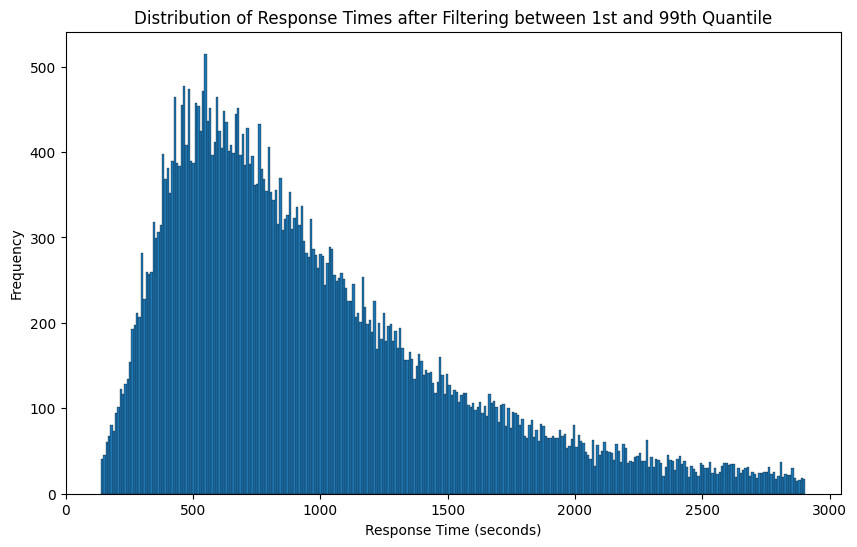

138.0
2905.0


In [12]:
# Assuming data_loader.processed_incidents_df gives you the DataFrame and you only want positive response times
df_processed = data_loader.processed_incidents_df
df_processed = df_processed[df_processed['response_time_sec'] > 0]
df_processed = df_processed[df_processed['triage_impression_during_call'].isin(['Critical', 'High Priority'])]

"""# First plot
plt.figure(figsize=(10, 6))
plt.hist(df_processed['response_time_sec'].sample(frac=0.10), bins=10000, edgecolor='black', linewidth=0)
plt.xlabel('Response Time (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Unfiltered Response Times')
plt.show()"""

# Second plot
plt.figure(figsize=(10, 6))
sampled_data = df_processed.sample(frac=0.10)
filtered_data_99 = remove_over_quantile(sampled_data, 'response_time_sec', 0.009, 0.95)
plt.hist(filtered_data_99['response_time_sec'], bins=300, edgecolor='black', linewidth=0.2)
plt.xlabel('Response Time (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Response Times after Filtering between 1st and 99th Quantile')
plt.show()

"""# Third plot
plt.figure(figsize=(10, 6))
sampled_data = df_processed.sample(frac=0.10)
filtered_data_95 = remove_over_quantile(sampled_data, 'response_time_sec', 0.05, 0.95)
plt.hist(filtered_data_95['response_time_sec'], bins=300, edgecolor='black', linewidth=0.2)
plt.xlabel('Response Time (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Response Times after Filtering between 5th and 95th Quantile')
plt.show()"""

print(filtered_data_99['response_time_sec'].min())
print(filtered_data_99['response_time_sec'].max())

## Filtering processed_incidents at 95th and 99th Quantile Without V1 and V2

In [13]:
"""# Assuming data_loader.processed_incidents_df gives you the DataFrame
df_processed = data_loader.processed_incidents_df

# Filter based on triage_impression_during_call
df_filtered = df_processed[df_processed['triage_impression_during_call'].isin(['Critical', 'High Priority', 'Moderate Priority'])]

# First plot
plt.figure(figsize=(10, 6))
plt.hist(df_filtered[df_filtered['response_time_sec'] > 0]['response_time_sec'].sample(frac=0.10), bins=10000, edgecolor='black', linewidth=0)
plt.xlabel('Response Time (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Unfiltered Response Times (Acute or Urgent)')
plt.show()

# Second plot
plt.figure(figsize=(10, 6))
sampled_data = df_filtered[df_filtered['response_time_sec'] > 0].sample(frac=0.10)
filtered_data_99 = remove_over_quantile(sampled_data, 'response_time_sec', 0.99)
plt.hist(filtered_data_99['response_time_sec'], bins=300, edgecolor='black', linewidth=0.2)
plt.xlabel('Response Time (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Response Times after Filtering at 99th Quantile (Acute or Urgent)')
plt.show()

# Third plot
plt.figure(figsize=(10, 6))
sampled_data = df_filtered[df_filtered['response_time_sec'] > 0].sample(frac=0.10)
filtered_data_95 = remove_over_quantile(sampled_data, 'response_time_sec', 0.95)
plt.hist(filtered_data_95['response_time_sec'], bins=300, edgecolor='black', linewidth=0.2)
plt.xlabel('Response Time (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Response Times after Filtering at 95th Quantile (Acute or Urgent)')
plt.show()"""

"# Assuming data_loader.processed_incidents_df gives you the DataFrame\ndf_processed = data_loader.processed_incidents_df\n\n# Filter based on triage_impression_during_call\ndf_filtered = df_processed[df_processed['triage_impression_during_call'].isin(['Critical', 'High Priority', 'Moderate Priority'])]\n\n# First plot\nplt.figure(figsize=(10, 6))\nplt.hist(df_filtered[df_filtered['response_time_sec'] > 0]['response_time_sec'].sample(frac=0.10), bins=10000, edgecolor='black', linewidth=0)\nplt.xlabel('Response Time (seconds)')\nplt.ylabel('Frequency')\nplt.title('Distribution of Unfiltered Response Times (Acute or Urgent)')\nplt.show()\n\n# Second plot\nplt.figure(figsize=(10, 6))\nsampled_data = df_filtered[df_filtered['response_time_sec'] > 0].sample(frac=0.10)\nfiltered_data_99 = remove_over_quantile(sampled_data, 'response_time_sec', 0.99)\nplt.hist(filtered_data_99['response_time_sec'], bins=300, edgecolor='black', linewidth=0.2)\nplt.xlabel('Response Time (seconds)')\nplt.ylabel(

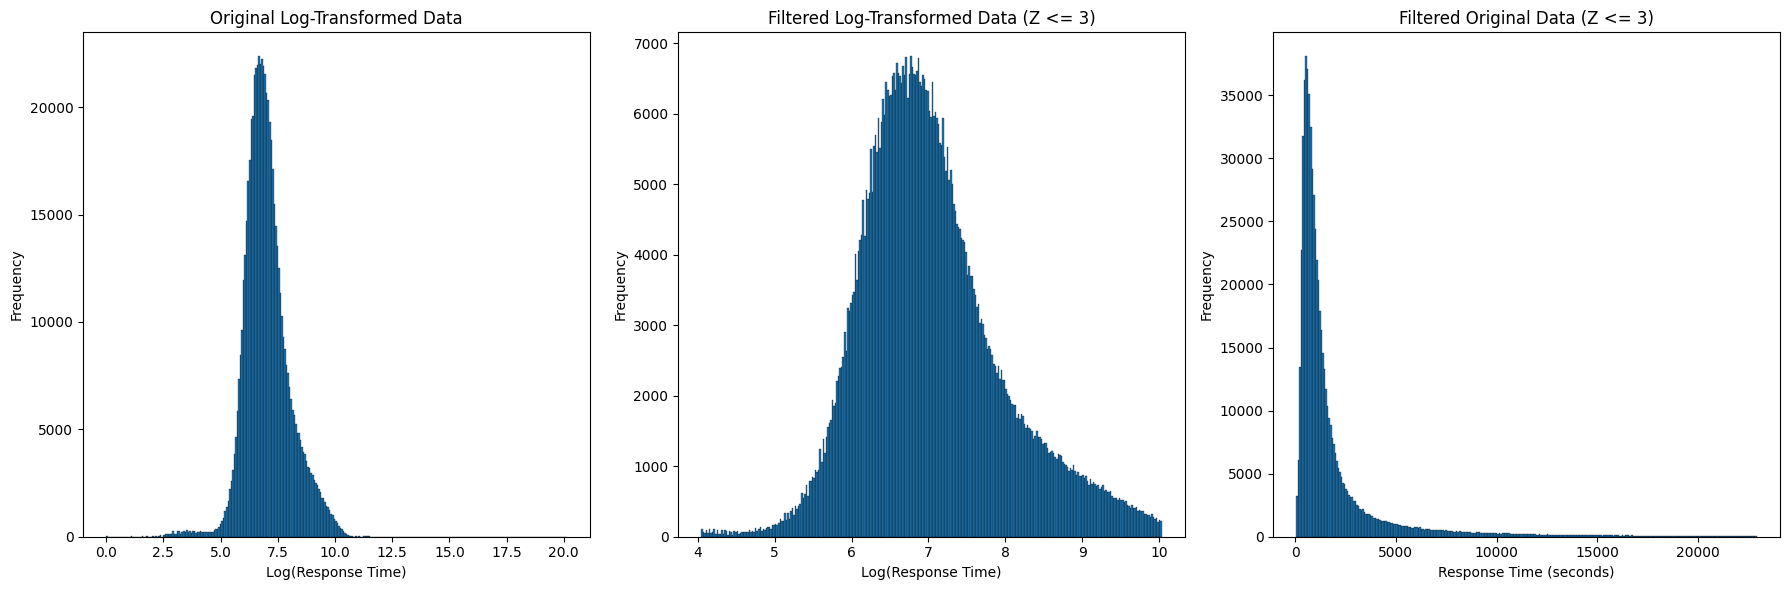

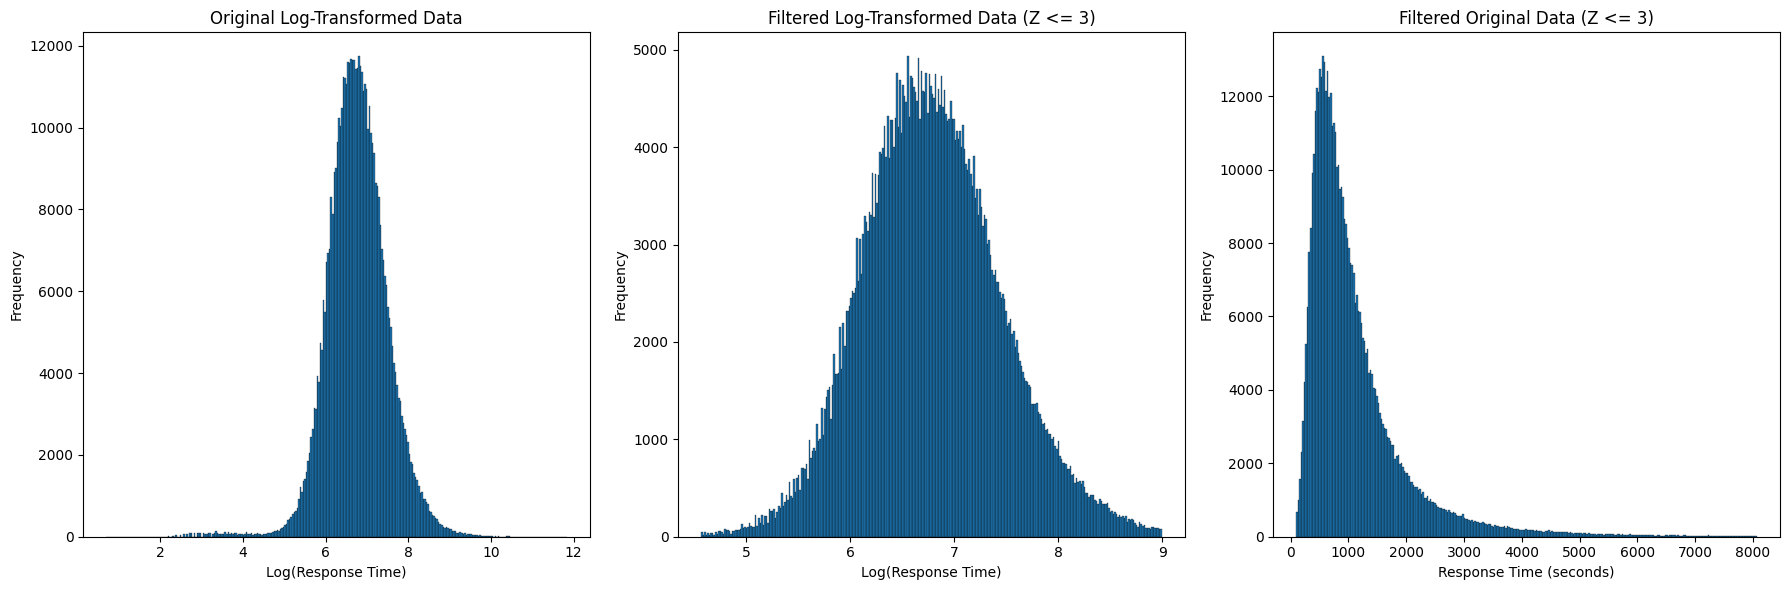

Original count: 754755
Removing negative response times: 657688
Only critical and high priority: 598815
After log transforming and removing with >=3: 518074
Lowest response time after slicing and dicing: 94.99999999999999 seconds
Highest response time after slicing and dicing: 8069.999999999994 seconds
80741


In [22]:
# Assuming data_loader.processed_incidents_df gives you the DataFrame and you only want positive response times
df_processed = data_loader.processed_incidents_df
df_processed = df_processed[df_processed['response_time_sec'] >= 0]
df_processed = df_processed[df_processed['triage_impression_during_call'].isin(['Critical', 'High Priority', 'Moderate Priority', 'Scheduled'])]
df_processed_log = np.log1p(df_processed['response_time_sec'])

# Calculate the mean and standard deviation of the log-transformed data
mean_log = np.mean(df_processed_log)
std_log = np.std(df_processed_log)

# Calculate the Z-scores for each data point in the log-transformed data
z_scores_log = (df_processed_log - mean_log) / std_log

# Remove data points where the absolute Z-score is greater than 3
df_processed_log_filtered = df_processed_log[np.abs(z_scores_log) <= 3]

# Transform the filtered log-transformed data back to the original scale
df_processed_filtered = np.expm1(df_processed_log_filtered)

# Plotting
plt.figure(figsize=(18, 6))

# Original log-transformed data
plt.subplot(1, 3, 1)
plt.hist(df_processed_log, bins=300, edgecolor='black', linewidth=0.2)
plt.xlabel('Log(Response Time)')
plt.ylabel('Frequency')
plt.title('Original Log-Transformed Data')

# Filtered log-transformed data
plt.subplot(1, 3, 2)
plt.hist(df_processed_log_filtered, bins=300, edgecolor='black', linewidth=0.2)
plt.xlabel('Log(Response Time)')
plt.ylabel('Frequency')
plt.title('Filtered Log-Transformed Data (Z <= 3)')

# Filtered original scale data
plt.subplot(1, 3, 3)
plt.hist(df_processed_filtered, bins=300, edgecolor='black', linewidth=0.2)
plt.xlabel('Response Time (seconds)')
plt.ylabel('Frequency')
plt.title('Filtered Original Data (Z <= 3)')

plt.tight_layout()
plt.show()

df_processed = data_loader.processed_incidents_df
df_processed = df_processed[df_processed['response_time_sec'] > 0]
df_processed = df_processed[df_processed['triage_impression_during_call'].isin(['Critical', 'High Priority'])]
df_processed_log = np.log1p(df_processed['response_time_sec'])

# Calculate the mean and standard deviation of the log-transformed data
mean_log = np.mean(df_processed_log)
std_log = np.std(df_processed_log)

# Calculate the Z-scores for each data point in the log-transformed data
z_scores_log = (df_processed_log - mean_log) / std_log

# Remove data points where the absolute Z-score is greater than 3
df_processed_log_filtered = df_processed_log[np.abs(z_scores_log) <= 3]

# Transform the filtered log-transformed data back to the original scale
df_processed_filtered = np.expm1(df_processed_log_filtered)

# Plotting
plt.figure(figsize=(18, 6))

# Original log-transformed data
plt.subplot(1, 3, 1)
plt.hist(df_processed_log, bins=300, edgecolor='black', linewidth=0.2)
plt.xlabel('Log(Response Time)')
plt.ylabel('Frequency')
plt.title('Original Log-Transformed Data')

# Filtered log-transformed data
plt.subplot(1, 3, 2)
plt.hist(df_processed_log_filtered, bins=300, edgecolor='black', linewidth=0.2)
plt.xlabel('Log(Response Time)')
plt.ylabel('Frequency')
plt.title('Filtered Log-Transformed Data (Z <= 3)')

# Filtered original scale data
plt.subplot(1, 3, 3)
plt.hist(df_processed_filtered, bins=300, edgecolor='black', linewidth=0.2)
plt.xlabel('Response Time (seconds)')
plt.ylabel('Frequency')
plt.title('Filtered Original Data (Z <= 3)')

plt.tight_layout()
plt.show()

df_processed = data_loader.processed_incidents_df
print(f"Original count: {len(df_processed)}")
df_processed_no_negatives = df_processed[df_processed['response_time_sec'] >= 0]
print(f"Removing negative response times: {len(df_processed_no_negatives)}")
df_processed_only_high_priority = df_processed[df_processed['triage_impression_during_call'].isin(['Critical', 'High Priority'])]
print(f"Only critical and high priority: {len(df_processed_only_high_priority)}")

print(f"After log transforming and removing with >=3: {len(df_processed_filtered)}")

print(f"Lowest response time after slicing and dicing: {df_processed_filtered.min()} seconds")
print(f"Highest response time after slicing and dicing: {df_processed_filtered.max()} seconds")

rows_before = len(df_processed_only_high_priority)
rows_after = len(df_processed_filtered)
rows_removed = rows_before - rows_after

print(rows_removed)

<bound method Series.count of 89162     300.000
89163    1200.000
89164    1080.000
89165    1020.000
89168    1020.000
           ...   
752215    983.000
753059    749.000
753110   1544.000
753693   3746.000
753917   1665.000
Name: response_time_sec, Length: 518074, dtype: float64>

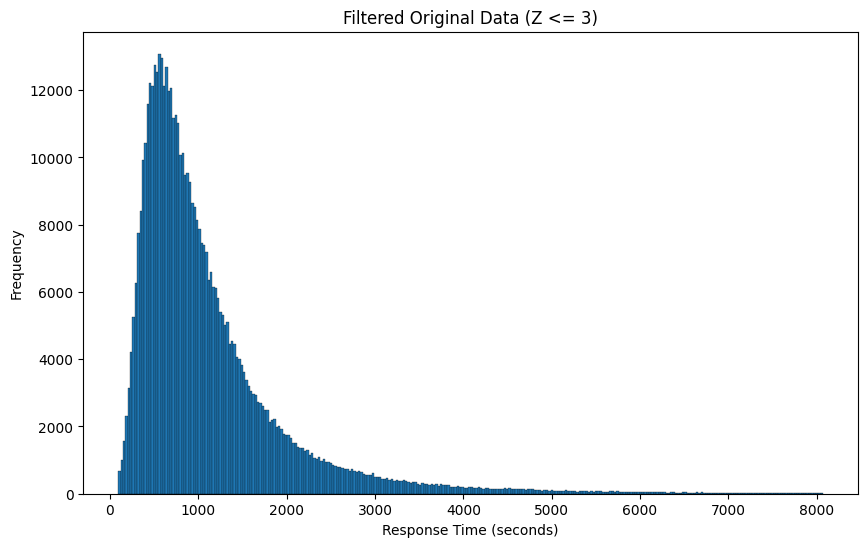

In [15]:
plt.figure(figsize=(10, 6))

# Filtered original scale data

plt.hist(df_processed_filtered, bins=300, edgecolor='black', linewidth=0.2)
plt.xlabel('Response Time (seconds)')
plt.ylabel('Frequency')
plt.title('Filtered Original Data (Z <= 3)')

df_processed_filtered.count

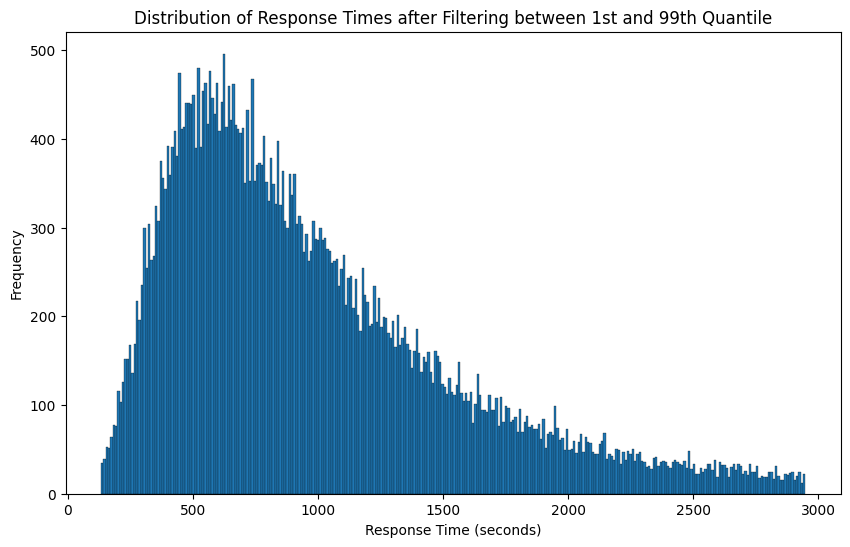

132.0
2948.0


In [16]:
# Assuming data_loader.processed_incidents_df gives you the DataFrame and you only want positive response times
df_processed = data_loader.processed_incidents_df
df_processed = df_processed[df_processed['response_time_sec'] > 0]
df_processed = df_processed[df_processed['triage_impression_during_call'].isin(['Critical', 'High Priority'])]

"""# First plot
plt.figure(figsize=(10, 6))
plt.hist(df_processed['response_time_sec'].sample(frac=0.10), bins=10000, edgecolor='black', linewidth=0)
plt.xlabel('Response Time (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Unfiltered Response Times')
plt.show()"""

# Second plot
plt.figure(figsize=(10, 6))
sampled_data = df_processed.sample(frac=0.10)
filtered_data_99 = remove_over_quantile(sampled_data, 'response_time_sec', 0.009, 0.95)
plt.hist(filtered_data_99['response_time_sec'], bins=300, edgecolor='black', linewidth=0.2)
plt.xlabel('Response Time (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Response Times after Filtering between 1st and 99th Quantile')
plt.show()

"""# Third plot
plt.figure(figsize=(10, 6))
sampled_data = df_processed.sample(frac=0.10)
filtered_data_95 = remove_over_quantile(sampled_data, 'response_time_sec', 0.05, 0.95)
plt.hist(filtered_data_95['response_time_sec'], bins=300, edgecolor='black', linewidth=0.2)
plt.xlabel('Response Time (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Response Times after Filtering between 5th and 95th Quantile')
plt.show()"""

print(filtered_data_99['response_time_sec'].min())
print(filtered_data_99['response_time_sec'].max())

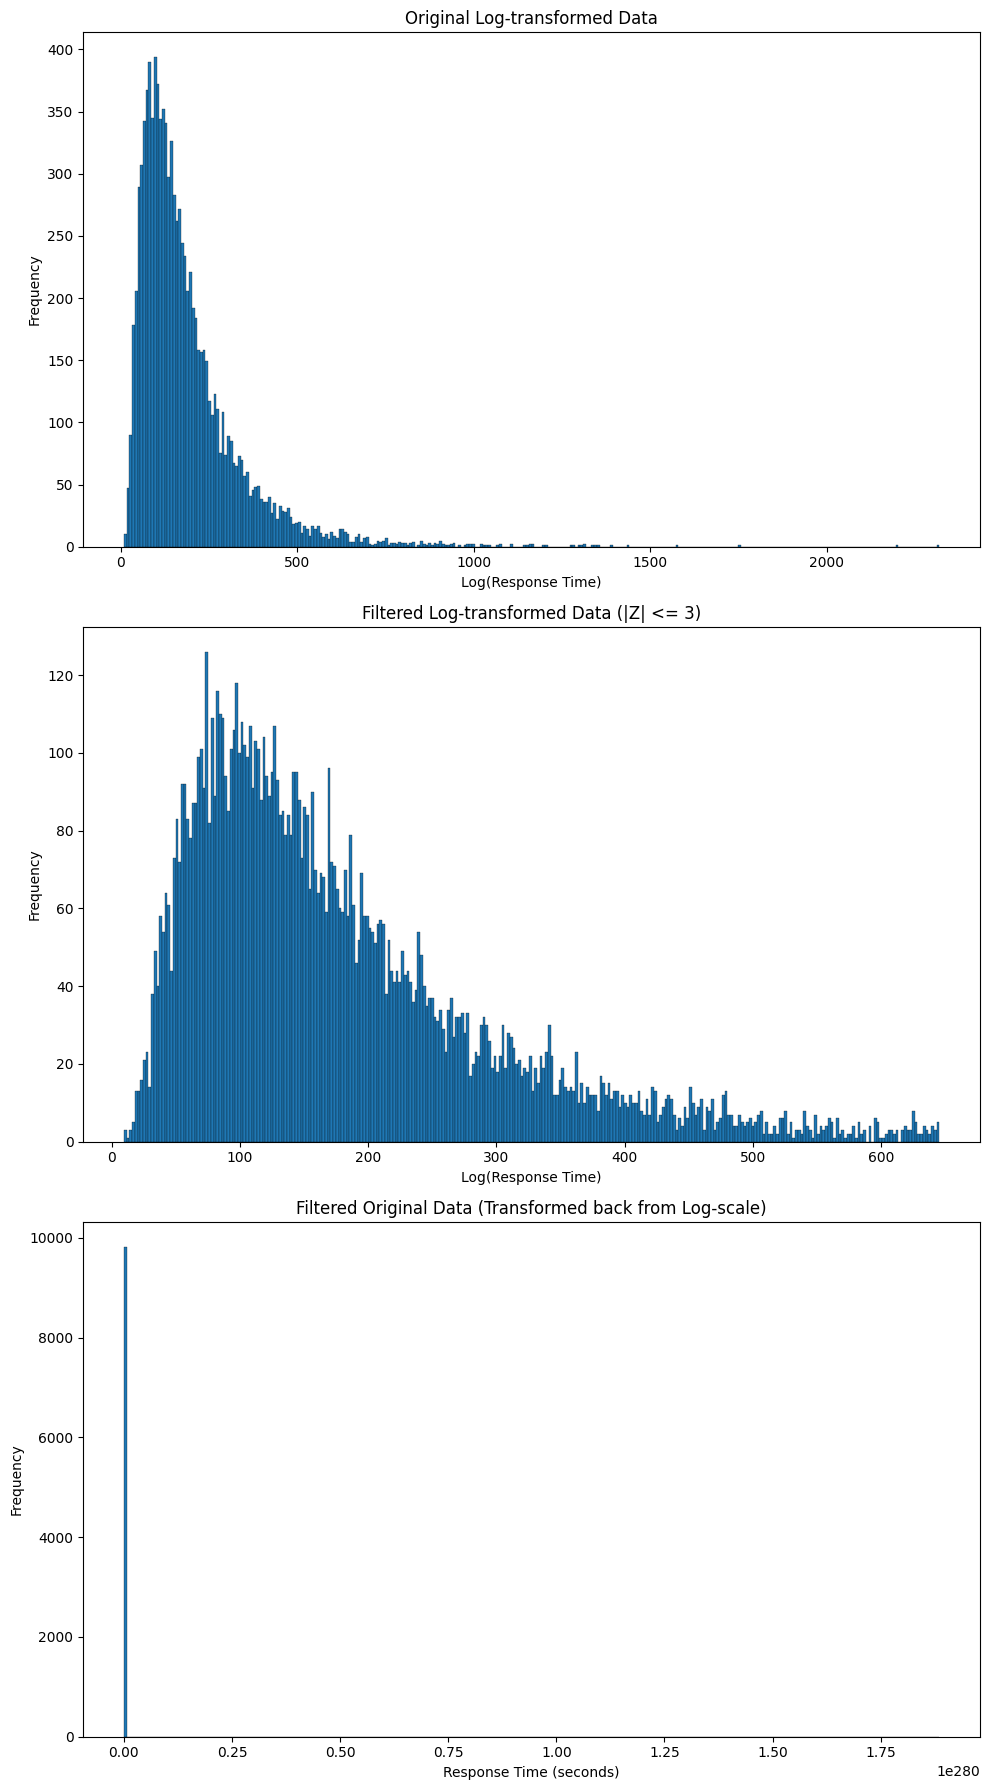

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Generating log-transformed data for demonstration (as I don't have the original data)
np.random.seed(42)
log_data = np.random.lognormal(mean=5, sigma=0.7, size=10000)

# Calculate the mean and standard deviation of the log-transformed data
mean_log = np.mean(log_data)
std_log = np.std(log_data)

# Calculate z-scores for each data point
z_scores_log = (log_data - mean_log) / std_log

# Filter out data points where the z-score is greater than 3 or less than -3
filtered_log_data = log_data[np.abs(z_scores_log) <= 3]

# Transform the filtered log data back to its original scale
filtered_original_data = np.expm1(filtered_log_data)  # using exp(x) - 1 to reverse the log1p transformation

# Plotting the histograms
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Plot original log-transformed data
axs[0].hist(log_data, bins=300, edgecolor='black', linewidth=0.2)
axs[0].set_title('Original Log-transformed Data')
axs[0].set_xlabel('Log(Response Time)')
axs[0].set_ylabel('Frequency')

# Plot filtered log-transformed data
axs[1].hist(filtered_log_data, bins=300, edgecolor='black', linewidth=0.2)
axs[1].set_title('Filtered Log-transformed Data (|Z| <= 3)')
axs[1].set_xlabel('Log(Response Time)')
axs[1].set_ylabel('Frequency')

# Plot filtered original-scale data
axs[2].hist(filtered_original_data, bins=300, edgecolor='black', linewidth=0.2)
axs[2].set_title('Filtered Original Data (Transformed back from Log-scale)')
axs[2].set_xlabel('Response Time (seconds)')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [18]:
test_df = data_loader.processed_incidents_df

# Convert all time columns to datetime format
time_columns = [
    'time_call_received', 'time_call_processed', 'time_ambulance_notified',
    'time_dispatch', 'time_arrival_scene', 'time_departure_scene',
    'time_arrival_hospital', 'time_available'
]
# Initialize the figure
plt.figure(figsize=(18, 12))

# Loop through the columns and plot the distribution of "good" time differences
for i, (key, _) in enumerate(stats_dict_bad_values.items()):
    col1, col2 = key.split(" > ")
    
    # Calculate time difference for good values in seconds
    time_diff_series_bad = (df_sample[df_sample[col1] > df_sample[col2]][col2] - 
                             df_sample[df_sample[col1] > df_sample[col2]][col1]).dt.total_seconds()
    
    plt.subplot(3, 3, i + 1)
    sns.histplot(time_diff_series_bad, bins=50, kde=False)
    plt.title(f'Distribution of {key}')
    plt.xlabel('Time Difference (seconds)')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

NameError: name 'stats_dict_bad_values' is not defined

<Figure size 1800x1200 with 0 Axes>

In [ ]:
# Sample code to check if there are any rows where time2 is before time1 in a DataFrame
test_df = data_loader.enhanced_incidents_df

# Initialize a dictionary to store counts of such instances for each pair of time columns
count_dict = {}
time_columns = [
    'time_call_received', 'time_call_processed', 'time_ambulance_notified',
    'time_dispatch', 'time_arrival_scene', 'time_departure_scene',
    'time_arrival_hospital', 'time_available'
]

# Loop through adjacent pairs of time columns to check
for i in range(len(time_columns) - 1):
    col1 = time_columns[i]
    col2 = time_columns[i + 1]
    
    # Count the number of rows where time2 is before time1
    count = len(test_df[test_df[col1] > test_df[col2]])
    
    # Store the count in the dictionary
    count_dict[f"{col1} > {col2}"] = count

count_dict

{'time_call_received > time_call_processed': 0,
 'time_call_processed > time_ambulance_notified': 0,
 'time_ambulance_notified > time_dispatch': 0,
 'time_dispatch > time_arrival_scene': 0,
 'time_arrival_scene > time_departure_scene': 0,
 'time_departure_scene > time_arrival_hospital': 0,
 'time_arrival_hospital > time_available': 0}

In [ ]:
"""# Convert all time columns to datetime format
time_columns = [
    'time_call_received', 'time_call_processed', 'time_ambulance_notified',
    'time_dispatch', 'time_arrival_scene', 'time_departure_scene',
    'time_arrival_hospital', 'time_available'
]
# Initialize the figure
plt.figure(figsize=(18, 12))


# Loop through the columns and plot the distribution of "good" time differences
for i, (key, _) in enumerate(stats_dict_bad_values.items()):
    col1, col2 = key.split(" > ")
    
    # Calculate time difference for good values in seconds
    time_diff_series_bad = (test_df[test_df[col1] > test_df[col2]][col2] - 
                             test_df[test_df[col1] > test_df[col2]][col1]).dt.total_seconds()
    
    plt.subplot(3, 3, i + 1)
    sns.histplot(time_diff_series_bad, bins=50, kde=False)
    plt.title(f'Distribution of {key}')
    plt.xlabel('Time Difference (seconds)')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()"""

'# Convert all time columns to datetime format\ntime_columns = [\n    \'time_call_received\', \'time_call_processed\', \'time_ambulance_notified\',\n    \'time_dispatch\', \'time_arrival_scene\', \'time_departure_scene\',\n    \'time_arrival_hospital\', \'time_available\'\n]\n# Initialize the figure\nplt.figure(figsize=(18, 12))\n\n\n# Loop through the columns and plot the distribution of "good" time differences\nfor i, (key, _) in enumerate(stats_dict_bad_values.items()):\n    col1, col2 = key.split(" > ")\n    \n    # Calculate time difference for good values in seconds\n    time_diff_series_bad = (test_df[test_df[col1] > test_df[col2]][col2] - \n                             test_df[test_df[col1] > test_df[col2]][col1]).dt.total_seconds()\n    \n    plt.subplot(3, 3, i + 1)\n    sns.histplot(time_diff_series_bad, bins=50, kde=False)\n    plt.title(f\'Distribution of {key}\')\n    plt.xlabel(\'Time Difference (seconds)\')\n    plt.ylabel(\'Frequency\')\n\nplt.tight_layout()\nplt.show(

In [ ]:
import pandas as pd
# Initialize a dictionary to keep the statistics for "good" datetime values
stats_dict_good_values = {}

df_sample = data_loader.enhanced_incidents_df

time_columns = [
    'time_call_received', 'time_call_processed', 'time_ambulance_notified',
    'time_dispatch', 'time_arrival_scene', 'time_departure_scene',
    'time_arrival_hospital', 'time_available'
]
df_sample[time_columns] = df_sample[time_columns].apply(pd.to_datetime, errors='coerce', format="%Y.%m.%dT%H:%M:%S")
        
# Loop through the columns and compare
for i in range(len(time_columns) - 1):
    col1 = time_columns[i]
    col2 = time_columns[i + 1]
    filtered_df_good = df_sample[df_sample[col1] <= df_sample[col2]]
    
    if not filtered_df_good.empty:
        # Calculate the time difference in seconds
        time_diff_series_good = (filtered_df_good[col2] - filtered_df_good[col1]).dt.total_seconds()
        
        # Calculate mean, median, and mode
        mean_time_diff_good = time_diff_series_good.mean()
        median_time_diff_good = time_diff_series_good.median()
        mode_time_diff_good = time_diff_series_good.mode()[0]  # Taking the first mode

        # Store the statistics in the dictionary
        stats_dict_good_values[f"{col1} <= {col2}"] = {
            'mean': mean_time_diff_good,
            'median': median_time_diff_good,
            'mode': mode_time_diff_good
        }

# Display the statistics for "good" datetime values
stats_dict_good_values

{'time_call_received <= time_call_processed': {'mean': 3262.421678955667,
  'median': 102.0,
  'mode': 45.0},
 'time_call_processed <= time_ambulance_notified': {'mean': 658.8536202315207,
  'median': 68.0,
  'mode': 4.0},
 'time_ambulance_notified <= time_dispatch': {'mean': 103.21219546948471,
  'median': 71.0,
  'mode': 4.0},
 'time_dispatch <= time_arrival_scene': {'mean': 583.5090119535205,
  'median': 476.0,
  'mode': 2.0},
 'time_arrival_scene <= time_departure_scene': {'mean': 1213.577041058083,
  'median': 1070.0,
  'mode': 2.0},
 'time_departure_scene <= time_arrival_hospital': {'mean': 1015.1713200955629,
  'median': 821.0,
  'mode': 2.0},
 'time_arrival_hospital <= time_available': {'mean': 1518.9536579109704,
  'median': 871.0,
  'mode': 2.0}}

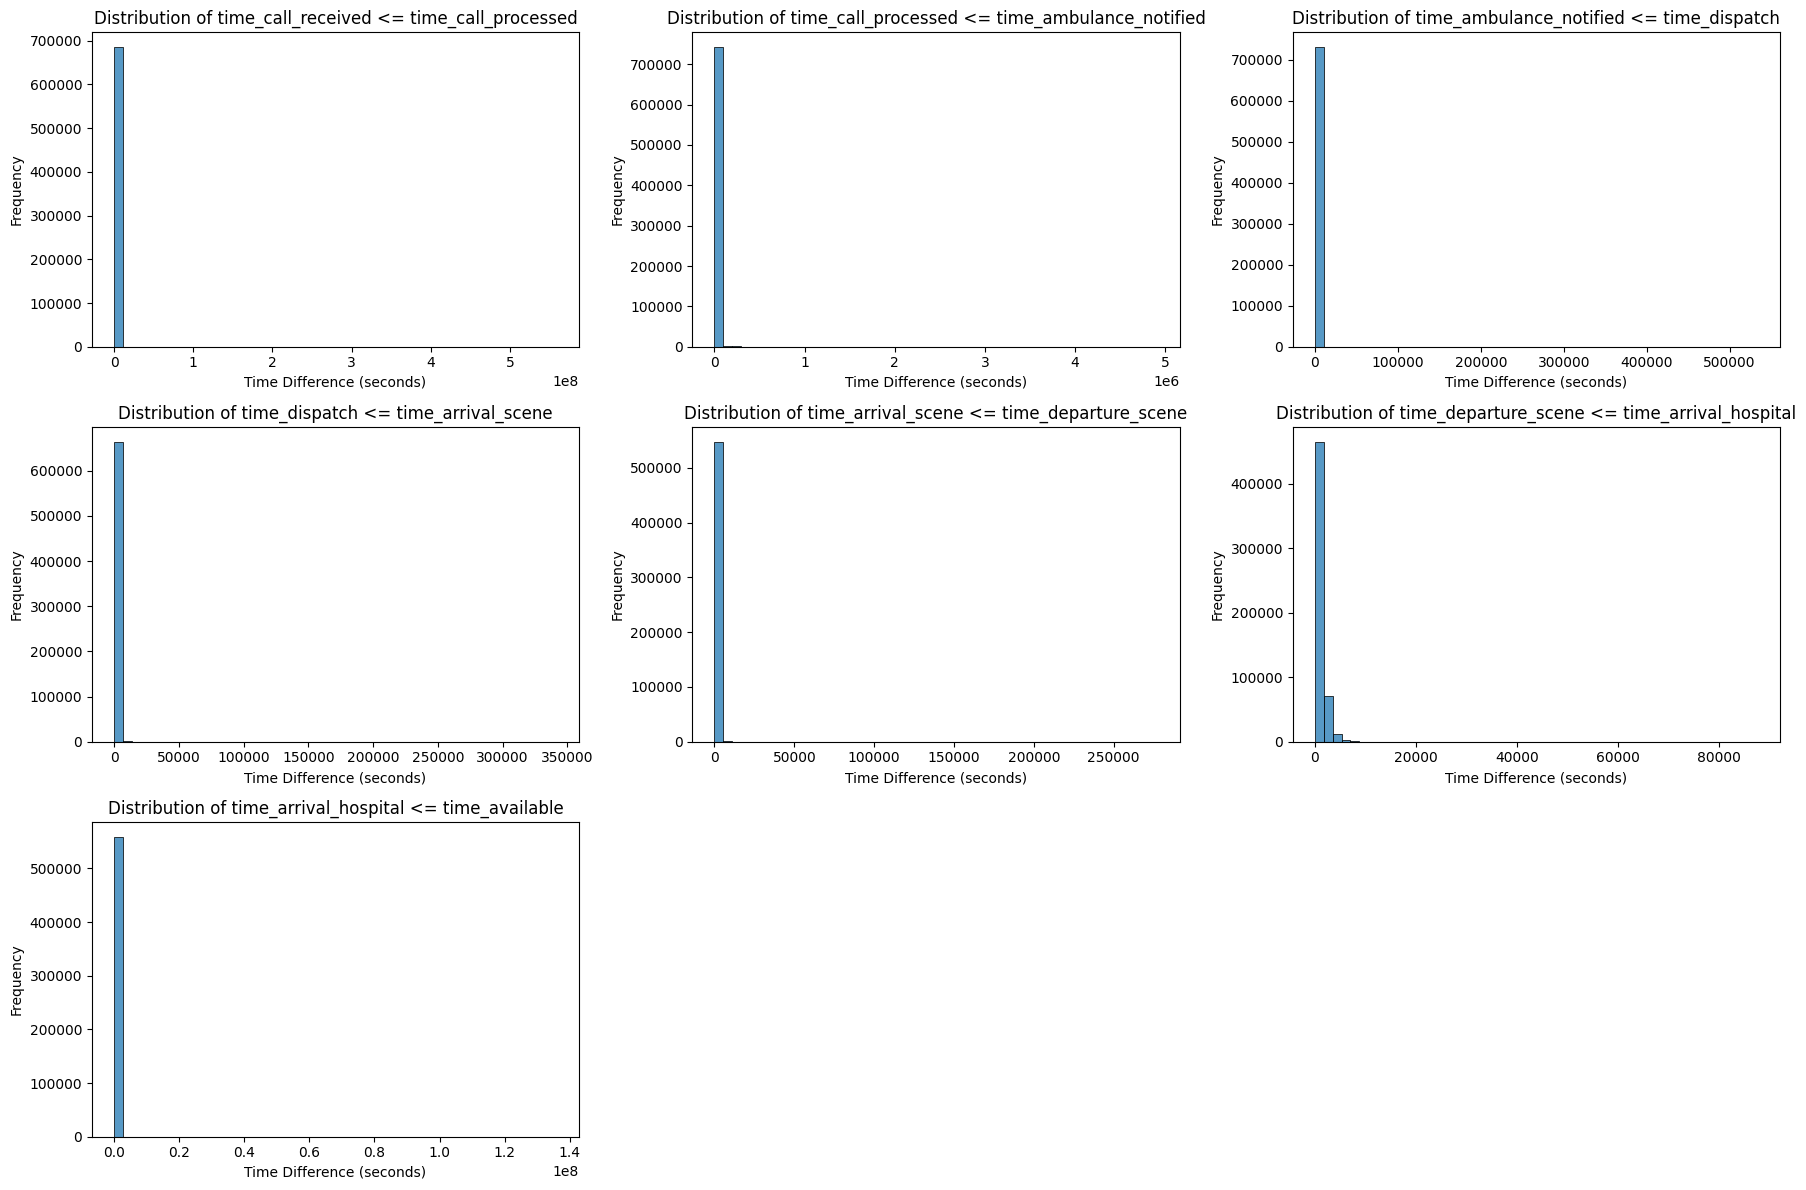

In [ ]:
# Initialize the figure
plt.figure(figsize=(18, 12))

# Loop through the columns and plot the distribution of "good" time differences
for i, (key, _) in enumerate(stats_dict_good_values.items()):
    col1, col2 = key.split(" <= ")
    
    # Calculate time difference for good values in seconds
    time_diff_series_good = (df_sample[df_sample[col1] <= df_sample[col2]][col2] - 
                             df_sample[df_sample[col1] <= df_sample[col2]][col1]).dt.total_seconds()
    
    plt.subplot(3, 3, i + 1)
    sns.histplot(time_diff_series_good, bins=50, kde=False)
    plt.title(f'Distribution of {key}')
    plt.xlabel('Time Difference (seconds)')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
# Create a sample DataFrame for demonstration; replace this with your actual data


df_sample = df

# Define time columns and a dictionary to store the quantile information
quantile_info = {}

# Calculate time differences in seconds and then divide into 5 quantiles
for i in range(len(time_columns) - 1):
    col1 = time_columns[i]
    col2 = time_columns[i + 1]
    
    # Calculate time difference for good values in seconds
    time_diff_series_good = (df_sample[df_sample[col1] <= df_sample[col2]][col2] - 
                             df_sample[df_sample[col1] <= df_sample[col2]][col1]).dt.total_seconds()
    
    
    # Divide the time differences into 5 quantiles
    quantiles = time_diff_series_good.quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    
    # Store the quantile information
    quantile_info[f"{col1} <= {col2}"] = quantiles

quantile_info

{'time_call_received <= time_call_processed': 0.1           27.0
 0.2           45.0
 0.3           62.0
 0.4           80.0
 0.5          103.0
 0.6          133.0
 0.7          179.0
 0.8          267.0
 0.9          570.0
 1.0    559528824.0
 dtype: float64,
 'time_call_processed <= time_ambulance_notified': 0.1         10.0
 0.2         20.0
 0.3         32.0
 0.4         50.0
 0.5         83.0
 0.6        149.0
 0.7        326.0
 0.8       1070.0
 0.9       5258.0
 1.0    4914937.0
 dtype: float64,
 'time_ambulance_notified <= time_dispatch': 0.1         4.0
 0.2         7.0
 0.3        18.0
 0.4        50.0
 0.5        71.0
 0.6        90.0
 0.7       112.0
 0.8       146.0
 0.9       215.0
 1.0    534073.0
 dtype: float64,
 'time_dispatch <= time_arrival_scene': 0.1       122.0
 0.2       231.0
 0.3       317.0
 0.4       399.0
 0.5       483.0
 0.6       582.0
 0.7       704.0
 0.8       886.0
 0.9      1218.4
 1.0    341981.0
 dtype: float64,
 'time_arrival_scene <= time_depar